In [1]:
from pandas_datareader import data as web
import yfinance as yf

In [2]:
dji = web.DataReader('^DJI', data_source = 'yahoo', start = '2000-01-01')
print(dji.head())
print('\n')
print(dji.shape)

                    High           Low          Open         Close     Volume  \
Date                                                                            
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000   
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000   
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000   
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000   
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000   

               Adj Close  
Date                      
2000-01-03  11357.509766  
2000-01-04  10997.929688  
2000-01-05  11122.650391  
2000-01-06  11253.259766  
2000-01-07  11522.559570  


(5264, 6)


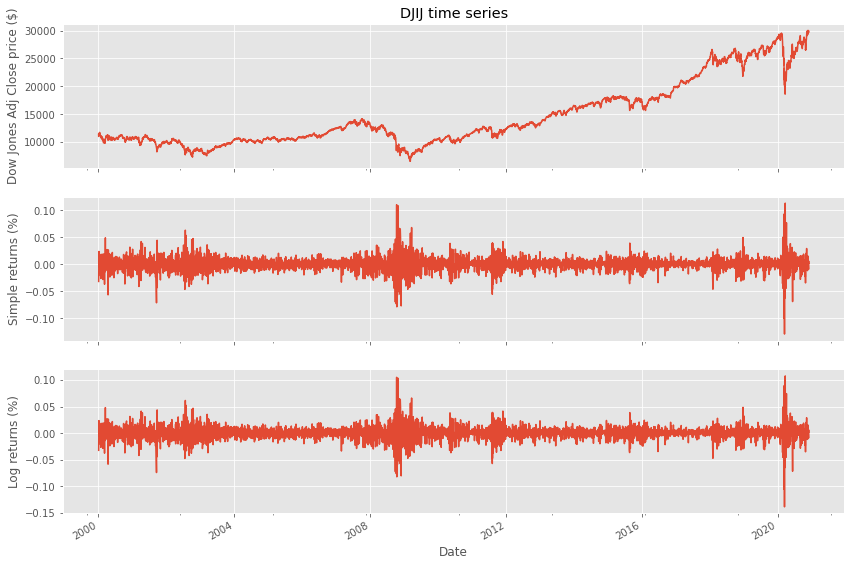

In [4]:
import numpy as np
import matplotlib.pyplot as plt

dji_series = dji['Adj Close']
#Calculate the simple and log returns using the adj close prices:
dji['simple_rtn'] = dji_series.pct_change()
dji['log_rtn'] = np.log(dji_series/dji_series.shift(1))
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
dji_series.plot(ax=ax[0])
ax[0].set(title = 'DJIJ time series', ylabel = 'Dow Jones Adj Close price ($)')
dji.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
dji.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', ylabel = 'Log returns (%)')
plt.show();

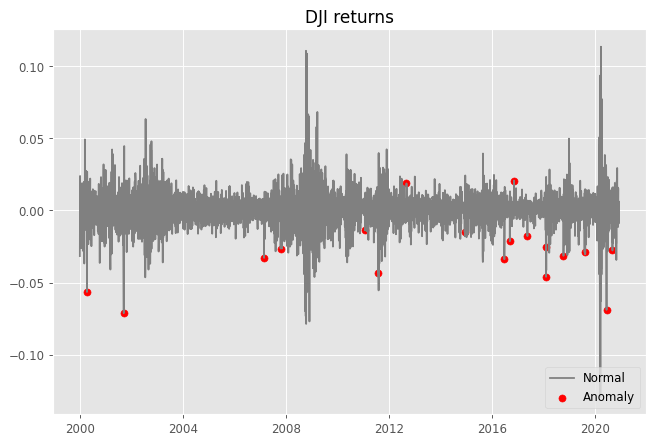

In [9]:
#Calculate the rolling mean and standard deviation:
df_rolling = dji[['simple_rtn']].rolling(window=21) .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

#Join the rolling metrics to the original data:
df_outliers = dji.join(df_rolling)

#Define a function for detecting outliers:
def indentify_outliers(row, n_sigmas=3):
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']

    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

#Identify the outliers and extract their values for later use
df_outliers['outlier'] = df_outliers.apply(indentify_outliers,axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1,['simple_rtn']]

#Plot the results:
fig, ax = plt.subplots(figsize = (9,6), dpi = 85)
ax.plot(df_outliers.index, df_outliers.simple_rtn, color='gray', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, color='red', label='Anomaly')
ax.set_title("DJI returns")
ax.legend(loc='lower right')
plt.show();

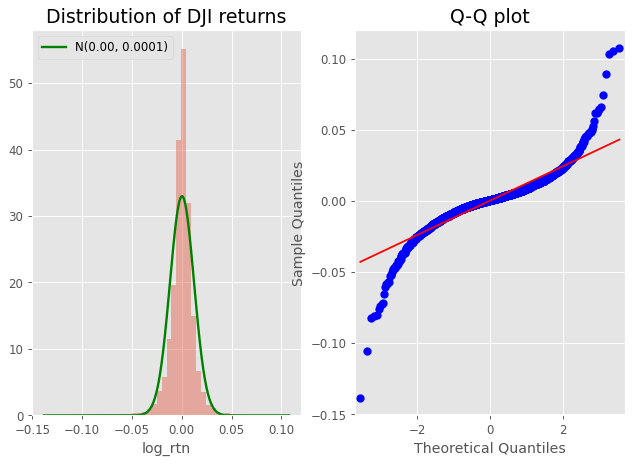

In [18]:
import scipy.stats as scs
import statsmodels.api as sm

r_range = np.linspace(min(dji['log_rtn'].dropna()), max(dji['log_rtn'].dropna()), num=1000)
mu = dji['log_rtn'].dropna().mean()
sigma = dji['log_rtn'].dropna().std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

#Plot the histogram and the Q-Q plot
fig, ax = plt.subplots(1, 2, figsize=(9, 6), dpi = 85)

# histogram
sns.distplot(dji['log_rtn'].dropna(), kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of DJI returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(dji['log_rtn'].dropna().values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)
plt.show();

In [22]:
print('kurtosis:', scs.kurtosis(dji['log_rtn'].dropna(), bias = False))
print('skewness:', scs.skew(dji['log_rtn'].dropna(), bias = False))
print('JB:', scs.jarque_bera(dji['log_rtn'].dropna()))

kurtosis: 12.993323441796973
skewness: -0.3759620012302713
JB: Jarque_beraResult(statistic=37069.36784763393, pvalue=0.0)


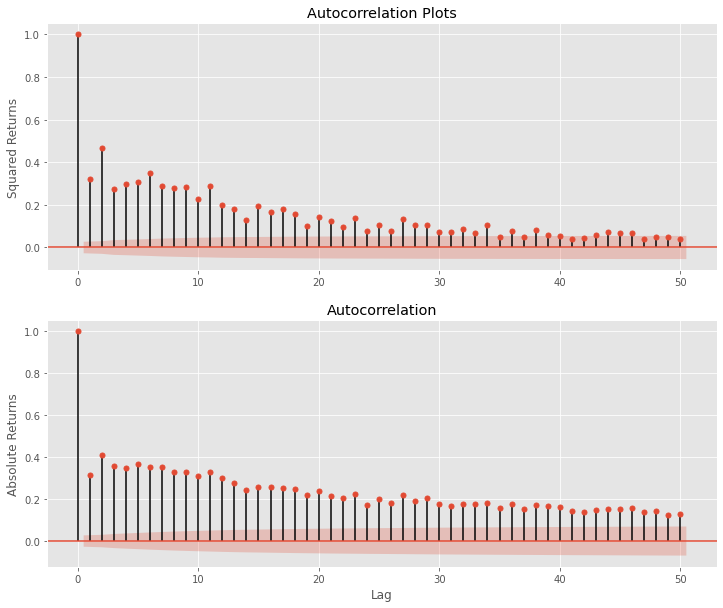

In [27]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

sm.graphics.tsa.plot_acf(dji['log_rtn'].dropna() ** 2, lags=N_LAGS,
alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation Plots', ylabel='Squared Returns')

sm.graphics.tsa.plot_acf(np.abs(dji['log_rtn'].dropna()), lags=N_LAGS,
alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',xlabel='Lag')

plt.show();

In [33]:
from fbprophet import Prophet


prophet = dji_series.reset_index() # reset index to get date_time as a column

# prepare the required data-frame
prophet.rename(columns={'Date':'ds','Adj Close':'y'},inplace=True)
prophet = prophet[['ds','y']]

train_percent = 0.90

# prepare train and test sets
train_size = int(prophet.shape[0]*train_percent)
train = prophet.iloc[:train_size]
test = prophet.iloc[train_size+1:]
model_prophet = Prophet(daily_seasonality=True)# build a prophet model
model_prophet.fit(train) # fit the model

# prepare a future dataframe
future_dates = model_prophet.make_future_dataframe(periods=test.shape[0])

# test.shape[0] = 515
forecast = model_prophet.predict(future_dates) # forecast values
model_prophet.plot(forecast) # plot for prediction
plt.title('Prediction on Test data')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
